In [2]:
!pip install torch torchvision numpy tqdm matplotlib torchmetrics scikit-learn

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from skimage.metrics import structural_similarity as ssim
from torchmetrics.image.fid import FrechetInceptionDistance
from sklearn.model_selection import train_test_split


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 48.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [3]:
# Download dataset
!wget "https://zenodo.org/records/3164691/files/QG_jets.npz?download=1" -O QG_jets.npz



--2025-04-03 10:53:33--  https://zenodo.org/records/3164691/files/QG_jets.npz?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106689379 (102M) [application/octet-stream]
Saving to: ‘QG_jets.npz’

QG_jets.npz         100%[===================>] 101.75M   554KB/s    in 3m 3s   

2025-04-03 10:56:37 (568 KB/s) - ‘QG_jets.npz’ saved [106689379/106689379]



In [4]:
data = np.load("QG_jets.npz", allow_pickle=True)
X = data["X"]  # Shape: (80000, 139, 4)
y = data["y"]  # Labels: quark (0) or gluon (1)

# Normalize data
X = (X - np.min(X)) / (np.max(X) - np.min(X))
X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # Shape: (80000, 1, 139, 4)

# Split dataset
train_size = int(0.8 * len(X))
test_size = len(X) - train_size
train_data, test_data = torch.utils.data.random_split(X, [train_size, test_size])
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [5]:
# Diffusion model components
# class UNet(nn.Module):
#     def __init__(self):
#         super(UNet, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU()
#         )
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, 1, kernel_size=3, padding=1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1, groups=1),  # Depthwise
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1, groups=1),  # Depthwise
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model, loss, optimizer
model = UNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
# Training loop
num_epochs = 10
tqdm_bar = tqdm(range(num_epochs))
for epoch in tqdm_bar:
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        noisy_input = batch + 0.1 * torch.randn_like(batch)
        optimizer.zero_grad()
        outputs = model(noisy_input)
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    tqdm_bar.set_description(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
mse_scores, ssim_scores = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        noisy_input = batch + 0.1 * torch.randn_like(batch)
        outputs = model(noisy_input)
        mse_scores.append(criterion(outputs, batch).item())
        ssim_scores.append(ssim(batch.cpu().numpy()[0, 0], outputs.cpu().numpy()[0, 0], win_size=3, data_range=1.0))
print(f"MSE: {np.mean(mse_scores):.4f}, SSIM: {np.mean(ssim_scores):.4f}")

Epoch 10, Loss: 0.0002: 100%|██████████| 10/10 [01:32<00:00,  9.22s/it]


MSE: 0.0002, SSIM: 0.9583


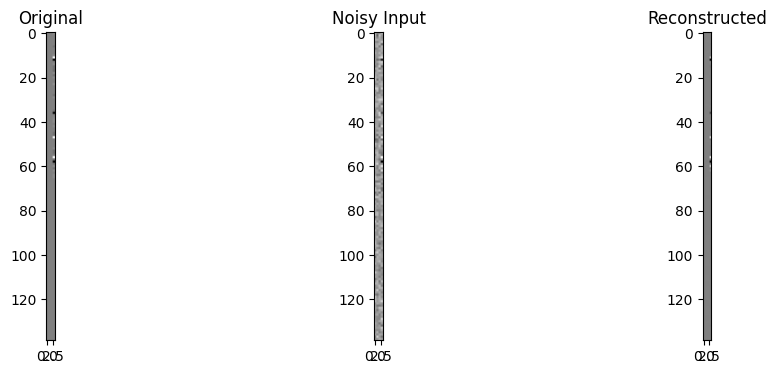

In [17]:
# Visualization
sample_batch = next(iter(test_loader)).to(device)
with torch.no_grad():
    noisy_sample = sample_batch + 0.1 * torch.randn_like(sample_batch)
    generated_sample = model(noisy_sample)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(sample_batch.cpu().numpy()[0, 0], cmap='gray')
ax[0].set_title("Original")
ax[1].imshow(noisy_sample.cpu().numpy()[0, 0], cmap='gray')
ax[1].set_title("Noisy Input")
ax[2].imshow(generated_sample.cpu().numpy()[0, 0], cmap='gray')
ax[2].set_title("Reconstructed")
plt.show()


##**Extending Classical Diffusion to Quantum Diffusion**
To extend the classical diffusion model to a quantum diffusion model, we can leverage Parameterized Quantum Circuits (PQCs) to simulate the forward and reverse diffusion processes. Instead of adding classical noise, we apply quantum noise channels (e.g., depolarization or amplitude damping) to transform an initial quantum state. The reverse process can be learned using variational quantum circuits, trained to reconstruct the target state using fidelity-based loss functions. A hybrid quantum-classical approach can be used, where a classical neural network estimates quantum parameters, similar to the role of the UNet in the given diffusion model. This approach could improve generative modeling by exploiting quantum entanglement and superposition, potentially enhancing expressivity and efficiency beyond classical methods.

####**Below is a detailed architecture outlining this extension:**

- Quantum Data Representation

Quantum State Encoding: Classical data is mapped onto quantum states using encoding techniques such as amplitude encoding or angle encoding. This process transforms classical information into a quantum format suitable for processing by quantum circuits.​

- Quantum Diffusion Process

Forward Process (Quantum Noise Application): In the quantum domain, the forward diffusion process involves applying quantum noise channels (e.g., depolarizing or amplitude damping channels) to the quantum states, progressively transforming them into a maximally mixed state. This mirrors the classical approach of adding noise to data but utilizes quantum noise mechanisms.​

Reverse Process (Parameterized Quantum Circuits): The reverse diffusion process is implemented using Parameterized Quantum Circuits (PQCs). These circuits are trained to invert the noise application, gradually reconstructing the original quantum state from the noisy state. The parameters of the PQCs are optimized to minimize the difference between the generated and target quantum states.​

- Hybrid Quantum-Classical Training

Classical Optimization of Quantum Parameters: Classical optimization algorithms are employed to adjust the parameters of the PQCs. The objective function for this optimization can be based on fidelity measures, aiming to maximize the overlap between the generated and target quantum states.​

Loss Function: A common choice for the loss function in this context is the infidelity between quantum states,
 . This function quantifies the dissimilarity between the target and generated states, guiding the optimization process.​

- Measurement and Data Extraction

Quantum Measurement: After the reverse diffusion process, quantum measurements are performed on the final quantum states to extract classical data. The measurement outcomes represent the generated data samples.​

Post-Processing: The measured data may undergo classical post-processing to map it back to the original data domain, ensuring compatibility with classical data formats.​

- Integration with Classical Systems

Hybrid Models: In practice, hybrid quantum-classical models can be constructed where certain components, such as data preprocessing and post-processing, are handled classically, while the core diffusion processes are managed quantum mechanically. This integration allows leveraging the strengths of both paradigms.​






